In [1]:
import time, copy, os, pickle, random
#import igraph
from scipy.io import loadmat
import pickle
import networkx as nx
import numpy as np
import pandas as pd
import base
import sys
import math
%matplotlib inline
#import ipyparallel as ipp
#import dill

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold

from collections import OrderedDict 

import matplotlib.pyplot as plt
from IPython.core.display import display, SVG, HTML
import tqdm as tqdm_c
from tqdm.notebook import tqdm
pd.options.display.max_columns = 150

In [2]:
def return_grid_search_random_forest():
    return RandomForestClassifier(n_estimators=100, 
                        min_samples_leaf=1, 
                            min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, bootstrap=True, 
                                oob_score=False, n_jobs=6, verbose=0, warm_start=False,
                                    max_depth = None,class_weight="balanced_subsample")

In [3]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [4]:
def return_connected_components(n=5):
    CONNECTED_COMPONENTS_PATH   = 'graphs'
    #excluded_list               = ['g_3_1', 'g_4_2','g_5_21','g_6_24',]
    excluded_list               = []
    LEN_OF_CONNECTED_COMPONENTS =  n
    dirs = []
    connected_graphs_components = OrderedDict() 
    for i in os.listdir(CONNECTED_COMPONENTS_PATH):
        if LEN_OF_CONNECTED_COMPONENTS >= int(i[3:]):
            dirs.append(i)


    for path in dirs:
        for count,file in enumerate(os.listdir(os.path.join(CONNECTED_COMPONENTS_PATH, path))): 
            file_path = os.path.join(CONNECTED_COMPONENTS_PATH, path, file)
            if file_path.endswith('.txt'): 
                connected_graph = igraph.load(file_path).as_undirected()
                if 'g_'+path[3:]+'_'+str(count+1) not in excluded_list or file_path.endswith('dir3\graph2.txt'):
                    connected_graphs_components['g_'+path[3:]+'_'+str(count+1)] =  nx.from_numpy_array(np.array(connected_graph.get_adjacency().data))
    return connected_graphs_components           

In [5]:
def return_dataset(file_name):
    #i = 'G_nci1'
    dd = base.fetch_dataset(file_name)
    graph_list = []
    for gg in dd.data:
        g_ = nx.Graph()
        g_.add_edges_from([(i[0], i[1]) for i in gg[0]])
        graph_list.append(g_)
    data_y = dd.target
    return graph_list, data_y

In [6]:
def return_compressed_graph_whole(g1, value, primeN):
    idx = 1
    data = OrderedDict() 
    #combined = []
    data[idx] = OrderedDict()
    # check if list is empty
    temp_graph = copy.copy(g1)
    
    gNew = nx.Graph()

    for v in value:
        gX = nx.Graph(g1.subgraph(v))
        gNew.add_nodes_from(gX.nodes())
        gNew.add_edges_from(gX.edges())

    gNew.remove_edges_from(nx.selfloop_edges(gNew))

    avDegrees = []
    connected_shapes = []

    for gX in list(connected_component_subgraphs(gNew)):
        sum = 0
        for key, value in gX.degree():
            sum += value
        sum /= len(gX.degree())
        #print(sum)
        avDegrees.append(sum)
        connected_shapes.append(list(gX.nodes()))
    
    # contract
    for i in connected_shapes:
        #combined.append(i[0])
        p = primeN        
        for node in i[1:]:
            temp_graph = nx.contracted_nodes(temp_graph, i[0], node, self_loops = False)
            p = p * g1.nodes[node]['layer']
        temp_graph.nodes[i[0]]['layer'] = p 
        
    return temp_graph, avDegrees

In [7]:
def retrurn_motif_count(graph, connected_graphs_components):
    return{counts_dict[key]:graph.count_subisomorphisms_vf2(subgraph) for key, subgraph in connected_graphs_components.items()}
  

In [8]:
#connected_graphs_components  = return_connected_components(n=6)       
def return_counts(g_, connected_graphs_components):
    data = OrderedDict()  # all the data indices goes here
    no_connected = OrderedDict() 
    count_dict = OrderedDict() 

    idx = 1

    g1 = g_
    #store indices of a connected graphs for a particular graph
    data[idx] = OrderedDict() 
    #iterating through connected graphs found in round1
    no_connected[idx] = OrderedDict() 
    #no_connected['before'] = OrderedDict() 
    count_dict = OrderedDict() 
    for name, graph in connected_graphs_components.items():
        GM = nx.isomorphism.MultiGraphMatcher(g1,graph)
        sub_nodes = list(GM.subgraph_isomorphisms_iter())
        if len(sub_nodes)>0:
            p = [list(i.keys()) for i in list(GM.subgraph_isomorphisms_iter())]
            sub_nodes = np.unique(np.sort(p,axis=1),axis=0)
        count_dict[name] = (sub_nodes)
        
    #print("count dict: " ,count_dict)
    counts = []
    for key, v in count_dict.items():
        counts.append(len(v))
    
    
    #data = pd.DataFrame(counts).transpose()
    #data_hist = counts.applymap(lambda x: len(x)) #contains histogram without merging connected shapes
    
    return counts, count_dict

In [9]:
def print_graphs(connected_graphs_components):
    i = 1
    k = len(connected_graphs_components)
    ky = 5
    kx = math.ceil(k/ky)

    plt.figure(figsize=(20, kx*ky))
    for key, g in connected_graphs_components.items():
        #plt.figure(i)
        plt.subplot(kx, ky, i)
        plt.title(key)
        nx.draw(g)
        i = i + 1
    return

In [10]:
def print_graphs2(givenGraphs, v):
    c = 1
    #connected_graphs_components  = return_connected_components(n=5)
    k = len(givenGraphs)
    ky = 10
    kx = math.ceil(k/ky)

    plt.figure(figsize=(20, 5))
    for key, gNew in givenGraphs.items():
        #plt.figure(c)
        plt.subplot(kx, ky, c)
        plt.title(key)
        
        
        labeldict = {}
        color_map = []

        for i in gNew.nodes():
            #print(i)
            j = gNew.nodes[i][v]
            labeldict[i] = j
            if (j == 1):
                color_map.append('yellow')
            elif (j == 2):
                color_map.append('#7777FF')
            elif (j == 3):
                color_map.append('red')
            else:
                color_map.append('white')
                
        nx.draw(gNew, labels = labeldict, node_color = color_map, with_labels=True, node_size = 100)
        
        
        c = c + 1
    return

In [11]:
def return_graph_stuff(graph, connected_graphs_components, label, indexKey):
    #counts, count_dict = return_counts(g_, connected_graphs_components)

    
    data_hist1, count_dict1 = return_counts(graph, connected_graphs_components)

    #pbar2 = tqdm_c(range(len(count_dict1)), desc="Computing Sub-Histogram")

    compressedGs = OrderedDict() 

    for key, value in count_dict1.items():

        currDict = OrderedDict() 
        data_histT = [0] * len(count_dict1)
        data_histT2 = [0] * len(count_dict1)
        
        numSepCounts = 6
        newnodes = 0
        newedges = 0
            
        data_histT3 = [0] * len(count_dict1) * numSepCounts
        avDegrees = []
        
        if (len(value) > 0):
            g2, avDegrees = return_compressed_graph_whole(graph, value, 2)
            newnodes = len(g2.nodes())
            newedges = len(g2.edges())
            
            data_histT, count_dict2 = return_counts(g2, connected_graphs_components)
            counts = []
            separateCounts = {}
            for i in range(numSepCounts):
                separateCounts[i + 1] = []
                
                
            for k, v in count_dict2.items():
                thiscount = 0
                # v is each 
                separateCountThis = {}
                for i in range(numSepCounts):
                    separateCountThis[i + 1] = 0
                
                # for each component present for this graphlet
                for oneV in v:
                    # one subset of connected components 
                    condition = False
                    numLayered = 0;
                    
                    for oneNode in oneV:
                        if (g2.nodes[oneNode]['layer'] == 2):
                            numLayered += 1
                            
                    if (numLayered > 0):
                        #print(oneV)
                        thiscount += 1
                        separateCountThis[numLayered] += 1
                    
                counts.append(thiscount)
                for i in range(numSepCounts):
                    separateCounts[i + 1].append(separateCountThis[i+1])

            data_histT2 = counts
            data_histT3 = []
            for i in range(numSepCounts):
                data_histT3 += separateCounts[i + 1]
                    
        #currDict['key'] = key

        currDict['nodes'] = [newnodes]
        currDict['edges'] = [newedges]
        currDict['degreeList'] = avDegrees
        currDict['HoG'] = data_histT
        currDict['HoGN'] = data_histT2
        currDict['HoGN2'] = data_histT3

        compressedGs[key] = currDict

        #pbar2.update(1)


    #pbar2.close()


    retDict = OrderedDict() 
    #retDict['graph'] = graph
    retDict['nodes'] = len(graph.nodes())
    retDict['edges'] = len(graph.edges())
    retDict['class'] = label
    retDict['key'] = indexKey
    retDict['HoG'] = data_hist1
    retDict['compressedGs'] = compressedGs

    return retDict


    

In [12]:
# we have, in results, a list of graphs with various information
#graph_item = results[0]

#for graph_item in results:
#    graph_item['compressedGs'][]
def ret_minmax(results, key):

    globMin = 110
    globMax = 0
    globMinG = 0
    globMaxG = 0

    #for key in connected_graphs_components.keys():
    #key = 'g_6_55'
    some = False
    for graph_item in results:
        if (len(graph_item['compressedGs'][key]['degreeList']) == 0):
            continue
        some = True
        possMin = np.min(graph_item['compressedGs'][key]['degreeList'])
        possMax = np.max(graph_item['compressedGs'][key]['degreeList'])

        if (possMax > globMax):
            globMax = possMax
            #globMaxG = graph_item['graph']
        if (possMin < globMin):
            globMin = possMin
            #globMinG = graph_item['graph']

    #print(" Max: ", globMax, " Min: ", globMin)
    glob = {}
    if (some == True):
        glob['min'] = globMin
        glob['max'] = globMax
    return glob



In [13]:
## from joblib import Parallel, delayed
from joblib import Parallel, delayed
import multiprocessing


In [37]:
connected_graphs_components = OrderedDict()
lim = 6

connected_graphs_components['g_3_cycle'] = nx.cycle_graph(3)
connected_graphs_components['g_3_path'] = nx.path_graph(3)


for i in range(4,lim+1):
    name_pre = 'g_'+str(i)+'_'
    connected_graphs_components[name_pre+'cycle'] = nx.cycle_graph(i)
    connected_graphs_components[name_pre+'path'] = nx.path_graph(i)
    connected_graphs_components[name_pre+'clique'] = nx.complete_graph(i)
    connected_graphs_components[name_pre+'star'] = nx.star_graph(i-1)
    
    

In [26]:
def return_connected_components(n=5):
	CONNECTED_COMPONENTS_PATH   = 'graphs'
	dirs = []
	connected_graphs_components = {}
	for i in os.listdir(CONNECTED_COMPONENTS_PATH):
		if n >= int(i[3:]):
			dirs.append(i)

	for path in dirs:
		for count,file in enumerate(os.listdir(os.path.join(CONNECTED_COMPONENTS_PATH, path))): 
			file_path = os.path.join(CONNECTED_COMPONENTS_PATH, path, file)
			if file_path.endswith('.txt'): 
				connected_graph = np.loadtxt(file_path)
				connected_graphs_components['g_'+path[3:]+'_'+str(count+1)] =  nx.from_numpy_array(np.array(connected_graph))
	return connected_graphs_components

connected_graphs_components = return_connected_components(n=6)


curr  = return_connected_components(n=6)

only_keep = ['g_3_1', 'g_4_2', 'g_5_21', 'g_6_24', 
			 'g_4_1', 'g_5_1', 'g_6_1', 
			 'g_3_2', 'g_4_4', 'g_5_6', 'g_6_55', 
			 'g_4_6', 'g_5_14', 'g_6_16']
			 
connected_graphs_components = OrderedDict()

for key, val in curr.items():
	if (key in only_keep):
		connected_graphs_components[key] = curr[key]
        


In [27]:
name = 'MUTAG'
    
graph_list, data_y = return_dataset(name)
#graph_list = graph_list[600:650]

for g in graph_list:
    nx.set_node_attributes(g, 1, 'layer')

num_cores = 2

if not os.path.exists(name):
    os.makedirs(name)

#if not (os.path.isfile(name + '/data_X_1_.txt') and os.path.isfile(name + '/data_X_2_.txt') and os.path.isfile(name + '/data_X_3_.txt')):
results = Parallel(n_jobs=num_cores, verbose=0)(delayed(
    return_graph_stuff)(graph_list[key], connected_graphs_components, data_y[key], key) for key in tqdm(range(len(graph_list))))

pickle.dump( results, open( name+"/"+name + "_G.p", "wb" ) )

results = pickle.load( open( name+"/"+name + "_G.p", "rb" ) )

glob = {}

for k in connected_graphs_components.keys():
    retD = ret_minmax(results, k)
    if (len(retD) > 0):
        glob[k] = retD
for k, v in glob.items():
    v['max'] = math.ceil(v['max'])
    v['min'] = math.floor(v['min'])

dataX_1 = []
dataX_2 = []
dataX_3 = []
dataX_4 = []

binD = 10

for graph_item in results:
    data_item = copy.copy(graph_item['HoG'])
    data_item2 = copy.copy(graph_item['HoG'])
    data_item3 = copy.copy(graph_item['HoG'])
    data_item4 = copy.copy(graph_item['HoG'])

    data_item.append(graph_item['nodes'])
    data_item2.append(graph_item['nodes'])
    data_item3.append(graph_item['nodes'])
    data_item4.append(graph_item['nodes'])

    data_item.append(graph_item['edges'])
    data_item2.append(graph_item['edges'])
    data_item3.append(graph_item['edges'])
    data_item4.append(graph_item['edges'])

    for key, value in graph_item['compressedGs'].items():
        if ((key not in glob.keys())):
            continue

        globMin = glob[key]['min']
        globMax = glob[key]['max']

        # set binwidth for this histogram
        binW = binD*(globMax-globMin)
        if (binW == 0):
            binW = 1

        # make histogram of degrees
        degreeHist = [0] * binW
        avDegrees = value['degreeList']
        if (len(avDegrees) > 0):
            #print(binW)
            hist, bin_edges = np.histogram(avDegrees, bins=binW, range=(globMin, globMax), normed=None, weights=None, density=None)
            degreeHist = hist.tolist()

        data_item += degreeHist
        data_item2 += degreeHist
        data_item3 += degreeHist
        data_item4 += degreeHist


        data_item += value['nodes']
        data_item2 += value['nodes']
        data_item3 += value['nodes']
        data_item4 += value['nodes']

        data_item += value['edges']
        data_item2 += value['edges']
        data_item3 += value['edges']
        data_item4 += value['edges']

        thisHoGD = [x-y for x, y in zip(value['HoG'], value['HoGN'])] 

        if (not all(item >= 0 for item in thisHoGD)):
            print("error")

        #data_item += thisHoGD
        #data_item += value['HoGN2']

        #data_item2 = copy.copy(data_item)
        #data_item3 = copy.copy(data_item)
        data_item += value['HoG']
        data_item4 += value['HoG']

        data_item2 += thisHoGD
        data_item3 += thisHoGD
        data_item4 += thisHoGD

        data_item2 += value['HoGN']
        data_item3 += value['HoGN2']


        data_item4 += value['HoGN']
        data_item4 += value['HoGN2']


    dataX_1.append(data_item)
    dataX_2.append(data_item2)
    dataX_3.append(data_item3)
    dataX_4.append(data_item4)


dataX_1_ = np.array(dataX_1)
dataX_2_ = np.array(dataX_2)
dataX_3_ = np.array(dataX_3)
dataX_4_ = np.array(dataX_4)

data_X_1_ = dataX_1_[:,~np.all(dataX_1_==0,axis=0)]
data_X_2_ = dataX_2_[:,~np.all(dataX_2_==0,axis=0)]
data_X_3_ = dataX_3_[:,~np.all(dataX_3_==0,axis=0)]
data_X_4_ = dataX_4_[:,~np.all(dataX_4_==0,axis=0)]



np.savetxt(name + '/data_X_1_.txt',data_X_1_)
np.savetxt(name + '/data_X_2_.txt',data_X_2_)
np.savetxt(name + '/data_X_3_.txt',data_X_3_)
np.savetxt(name + '/data_X_4_.txt',data_X_4_)

Extracting dataset  MUTAG..
Parsing dataset  MUTAG..
Parse was succesful..
Deleting unzipped dataset files..
Going back to the original directory..


In [ ]:
def pad_to_length(x, m):
            return np.pad(x,(0, m - len(x)), mode = 'constant')
    
for name in tqdm(['PROTEINS','ENZYMES', 'DD'], desc='dataset'):
    #name = "NCI109"
    
    graph_list, data_y = return_dataset(name)

    for g in graph_list:
        nx.set_node_attributes(g, 1, 'layer')

    num_cores = multiprocessing.cpu_count()
    
    if not os.path.exists(name):
        os.makedirs(name)
        
    if not (os.path.isfile(name + '/data_X_1_.txt') and os.path.isfile(name + '/data_X_2_.txt') and os.path.isfile(name + '/data_X_3_.txt')):
        results = Parallel(n_jobs=1, verbose=0)(delayed(
            return_graph_stuff)(graph_list[key], connected_graphs_components, data_y[key], key) for key in tqdm(range(len(graph_list))))

        pickle.dump( results, open( name+"/"+name + "_G.p", "wb" ) )

    results = pickle.load( open( name+"/"+name + "_G.p", "rb" ) )
    glob = {}

    for k in connected_graphs_components.keys():
        retD = ret_minmax(results, k)
        if (len(retD) > 0):
            glob[k] = retD
    for k, v in glob.items():
        v['max'] = math.ceil(v['max'])
        v['min'] = math.floor(v['min'])

    dataX_1 = []
    dataX_2 = []
    dataX_3 = []
    dataX_4 = []

    binD = 10

    for graph_item in results:
        data_item = copy.copy(graph_item['HoG'])
        data_item2 = copy.copy(graph_item['HoG'])
        data_item3 = copy.copy(graph_item['HoG'])
        data_item4 = copy.copy(graph_item['HoG'])

        data_item.append(graph_item['nodes'])
        data_item2.append(graph_item['nodes'])
        data_item3.append(graph_item['nodes'])
        data_item4.append(graph_item['nodes'])

        data_item.append(graph_item['edges'])
        data_item2.append(graph_item['edges'])
        data_item3.append(graph_item['edges'])
        data_item4.append(graph_item['edges'])

        for key, value in graph_item['compressedGs'].items():
            if ((key not in glob.keys())):
                continue

            globMin = glob[key]['min']
            globMax = glob[key]['max']

            # set binwidth for this histogram
            binW = binD*(globMax-globMin)
            if (binW == 0):
                binW = 1

            # make histogram of degrees
            degreeHist = [0] * binW
            avDegrees = value['degreeList']
            if (len(avDegrees) > 0):
                #print(binW)
                hist, bin_edges = np.histogram(avDegrees, bins=binW, range=(globMin, globMax), normed=None, weights=None, density=None)
                degreeHist = hist.tolist()

            data_item += degreeHist
            data_item2 += degreeHist
            data_item3 += degreeHist
            data_item4 += degreeHist


            data_item += value['nodes']
            data_item2 += value['nodes']
            data_item3 += value['nodes']
            data_item4 += value['nodes']

            data_item += value['edges']
            data_item2 += value['edges']
            data_item3 += value['edges']
            data_item4 += value['edges']

            thisHoGD = [x-y for x, y in zip(value['HoG'], value['HoGN'])] 

            if (not all(item >= 0 for item in thisHoGD)):
                print("error")

            #data_item += thisHoGD
            #data_item += value['HoGN2']

            #data_item2 = copy.copy(data_item)
            #data_item3 = copy.copy(data_item)
            data_item += value['HoG']
            data_item4 += value['HoG']

            data_item2 += thisHoGD
            data_item3 += thisHoGD
            data_item4 += thisHoGD

            data_item2 += value['HoGN']
            data_item3 += value['HoGN2']


            data_item4 += value['HoGN']
            data_item4 += value['HoGN2']


        dataX_1.append(data_item)
        dataX_2.append(data_item2)
        dataX_3.append(data_item3)
        dataX_4.append(data_item4)


    dataX_1_ = np.array(dataX_1)
    dataX_2_ = np.array(dataX_2)
    dataX_3_ = np.array(dataX_3)
    dataX_4_ = np.array(dataX_4)

    data_X_1_ = dataX_1_[:,~np.all(dataX_1_==0,axis=0)]
    data_X_2_ = dataX_2_[:,~np.all(dataX_2_==0,axis=0)]
    data_X_3_ = dataX_3_[:,~np.all(dataX_3_==0,axis=0)]
    data_X_4_ = dataX_4_[:,~np.all(dataX_4_==0,axis=0)]

    

    np.savetxt(name + '/data_X_1_.txt',data_X_1_)
    np.savetxt(name + '/data_X_2_.txt',data_X_2_)
    np.savetxt(name + '/data_X_3_.txt',data_X_3_)
    np.savetxt(name + '/data_X_4_.txt',data_X_4_)
    
    
    data_X = pd.DataFrame(dataX_3_)
    
    #data_X = data1
    
    max_arr1 = []
    max_arr2 = []
    max_arr3 = []
    
    data_sdp = pickle.load(open(name+"_X.p", "rb" ) )
    max_len = max(map(lambda x: len(x), data_sdp))
    data_sdp = np.array([pad_to_length(np.array(i),max_len) for i in data_sdp])

    N_JOBS = multiprocessing.cpu_count() - 4
    for seed in tqdm([567,890,5678,78, 6,1122,101,11111,42,345], desc='training'):
        
        data_X     = np.array(pd.DataFrame(dataX_1_))
        data_X      = np.array([np.hstack((data_X[i],data_sdp[i])) for i in range(len(data_X))])
        estimator  = RandomForestClassifier(criterion='gini', max_depth=None, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                                                max_leaf_nodes=None, bootstrap=True, 
                                                oob_score=False, n_jobs=N_JOBS,verbose=0, warm_start=False,
                                                class_weight=None)

        param_grid = {'n_estimators':[50,100,500], 'max_features':['sqrt'], 'min_samples_split':[2,3,4,5]}
        kf = StratifiedKFold(n_splits=10, random_state = seed, shuffle = True)
        grid_rf    = GridSearchCV(estimator, param_grid, scoring=None, n_jobs=1, 
                     iid=False, refit=True, cv=kf, verbose=0, pre_dispatch='n_jobs', 
                     error_score='raise-deprecating')
        #print(data_X.shape)
        grid_rf.fit(data_X, data_y)
        df = pd.DataFrame(grid_rf.cv_results_)
        max_arr1.append(df['mean_test_score'].max())
        #grid_rf.cv_results_['mean_test_score']
        #Pipeline2 = Pipeline([('drop_empty_column', dropCols(frac=1.0)),('grid_rf', grid_rf)])
        #res = Pipeline2.fit(data_X, data_y)
    
        data_X     = np.array(pd.DataFrame(dataX_2_))
        data_X      = np.array([np.hstack((data_X[i],data_sdp[i])) for i in range(len(data_X))])
        estimator  = RandomForestClassifier(criterion='gini', max_depth=None, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                                                max_leaf_nodes=None, bootstrap=True, 
                                                oob_score=False, n_jobs= N_JOBS,verbose=0, warm_start=False,
                                                class_weight=None)

        param_grid = {'n_estimators':[50,100,500], 'max_features':['sqrt'], 'min_samples_split':[2,3,4,5]}
        kf = StratifiedKFold(n_splits=10, random_state = seed, shuffle = True)
        grid_rf    = GridSearchCV(estimator, param_grid, scoring=None, n_jobs=1, 
                     iid=False, refit=True, cv=kf, verbose=0, pre_dispatch='n_jobs', 
                     error_score='raise-deprecating')
        #print(data_X.shape)
        grid_rf.fit(data_X, data_y)
        df = pd.DataFrame(grid_rf.cv_results_)
        max_arr2.append(df['mean_test_score'].max())
        #grid_rf.cv_results_['mean_test_score']
        #Pipeline2 = Pipeline([('drop_empty_column', dropCols(frac=1.0)),('grid_rf', grid_rf)])
        #res = Pipeline2.fit(data_X, data_y)
    
    
        data_X     = np.array(pd.DataFrame(dataX_3_))
        data_X      = np.array([np.hstack((data_X[i],data_sdp[i])) for i in range(len(data_X))])
        estimator  = RandomForestClassifier(criterion='gini', max_depth=None, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                                                max_leaf_nodes=None, bootstrap=True, 
                                                oob_score=False, n_jobs= N_JOBS,verbose=0, warm_start=False,
                                                class_weight=None)

        param_grid = {'n_estimators':[50,100,500], 'max_features':['sqrt'], 'min_samples_split':[2,3,4,5]}
        kf = StratifiedKFold(n_splits=10, random_state = seed, shuffle = True)
        grid_rf    = GridSearchCV(estimator, param_grid, scoring=None, n_jobs=1, 
                     iid=False, refit=True, cv=kf, verbose=0, pre_dispatch='n_jobs', 
                     error_score='raise-deprecating')
        #print(data_X.shape)
        grid_rf.fit(data_X, data_y)
        df = pd.DataFrame(grid_rf.cv_results_)
        max_arr3.append(df['mean_test_score'].max())
        #grid_rf.cv_results_['mean_test_score']
        #Pipeline2 = Pipeline([('drop_empty_column', dropCols(frac=1.0)),('grid_rf', grid_rf)])
        #res = Pipeline2.fit(data_X, data_y)
        
    print('Result computed for', name, ' 1 results are:',np.mean(max_arr1))
    print('Result computed for', name, ' 2 results are:',np.mean(max_arr2))
    print('Result computed for', name, '3 results are:',np.mean(max_arr3))
    
    np.savetxt('results_HOSD/'+name+'_1_'+'.csv', max_arr1)
    np.savetxt('results_HOSD/'+name+'_2_'+'.csv', max_arr2)
    np.savetxt('results_HOSD/'+name+'_3_'+'.csv', max_arr3)
    
    

In [ ]:
for name in tqdm(['PROTEINS','ENZYMES', 'DD'], desc='dataset'):
    #name = "NCI109"
    
    graph_list, data_y = return_dataset(name)

    for g in graph_list:
        nx.set_node_attributes(g, 1, 'layer')

    num_cores = multiprocessing.cpu_count()
    
    if not os.path.exists(name):
        os.makedirs(name)
        
    if not (os.path.isfile(name + '/data_X_1_.txt') and os.path.isfile(name + '/data_X_2_.txt') and os.path.isfile(name + '/data_X_3_.txt')):
        results = Parallel(backend='threading',n_jobs=4, verbose=0)(delayed(
            return_graph_stuff)(graph_list[key], connected_graphs_components, data_y[key], key) for key in tqdm(range(len(graph_list))))

        pickle.dump( results, open( name+"/"+name + "_G.p", "wb" ) )

    results = pickle.load( open( name+"/"+name + "_G.p", "rb" ) )
    glob = {}

    for k in connected_graphs_components.keys():
        retD = ret_minmax(results, k)
        if (len(retD) > 0):
            glob[k] = retD
    for k, v in glob.items():
        v['max'] = math.ceil(v['max'])
        v['min'] = math.floor(v['min'])

    dataX_1 = []
    dataX_2 = []
    dataX_3 = []
    dataX_4 = []

    binD = 10

    for graph_item in results:
        data_item = copy.copy(graph_item['HoG'])
        data_item2 = copy.copy(graph_item['HoG'])
        data_item3 = copy.copy(graph_item['HoG'])
        data_item4 = copy.copy(graph_item['HoG'])

        data_item.append(graph_item['nodes'])
        data_item2.append(graph_item['nodes'])
        data_item3.append(graph_item['nodes'])
        data_item4.append(graph_item['nodes'])

        data_item.append(graph_item['edges'])
        data_item2.append(graph_item['edges'])
        data_item3.append(graph_item['edges'])
        data_item4.append(graph_item['edges'])

        for key, value in graph_item['compressedGs'].items():
            if ((key not in glob.keys())):
                continue

            globMin = glob[key]['min']
            globMax = glob[key]['max']

            # set binwidth for this histogram
            binW = binD*(globMax-globMin)
            if (binW == 0):
                binW = 1

            # make histogram of degrees
            degreeHist = [0] * binW
            avDegrees = value['degreeList']
            if (len(avDegrees) > 0):
                #print(binW)
                hist, bin_edges = np.histogram(avDegrees, bins=binW, range=(globMin, globMax), normed=None, weights=None, density=None)
                degreeHist = hist.tolist()

            data_item += degreeHist
            data_item2 += degreeHist
            data_item3 += degreeHist
            data_item4 += degreeHist


            data_item += value['nodes']
            data_item2 += value['nodes']
            data_item3 += value['nodes']
            data_item4 += value['nodes']

            data_item += value['edges']
            data_item2 += value['edges']
            data_item3 += value['edges']
            data_item4 += value['edges']

            thisHoGD = [x-y for x, y in zip(value['HoG'], value['HoGN'])] 

            if (not all(item >= 0 for item in thisHoGD)):
                print("error")

            #data_item += thisHoGD
            #data_item += value['HoGN2']

            #data_item2 = copy.copy(data_item)
            #data_item3 = copy.copy(data_item)
            data_item += value['HoG']
            data_item4 += value['HoG']

            data_item2 += thisHoGD
            data_item3 += thisHoGD
            data_item4 += thisHoGD

            data_item2 += value['HoGN']
            data_item3 += value['HoGN2']


            data_item4 += value['HoGN']
            data_item4 += value['HoGN2']


        dataX_1.append(data_item)
        dataX_2.append(data_item2)
        dataX_3.append(data_item3)
        dataX_4.append(data_item4)


    dataX_1_ = np.array(dataX_1)
    dataX_2_ = np.array(dataX_2)
    dataX_3_ = np.array(dataX_3)
    dataX_4_ = np.array(dataX_4)

    data_X_1_ = dataX_1_[:,~np.all(dataX_1_==0,axis=0)]
    data_X_2_ = dataX_2_[:,~np.all(dataX_2_==0,axis=0)]
    data_X_3_ = dataX_3_[:,~np.all(dataX_3_==0,axis=0)]
    data_X_4_ = dataX_4_[:,~np.all(dataX_4_==0,axis=0)]

    

    np.savetxt(name + '/data_X_1_.txt',data_X_1_)
    np.savetxt(name + '/data_X_2_.txt',data_X_2_)
    np.savetxt(name + '/data_X_3_.txt',data_X_3_)


Extracting dataset  PROTEINS..
Parsing dataset  PROTEINS..
Parse was succesful..
Deleting unzipped dataset files..
Going back to the original directory..


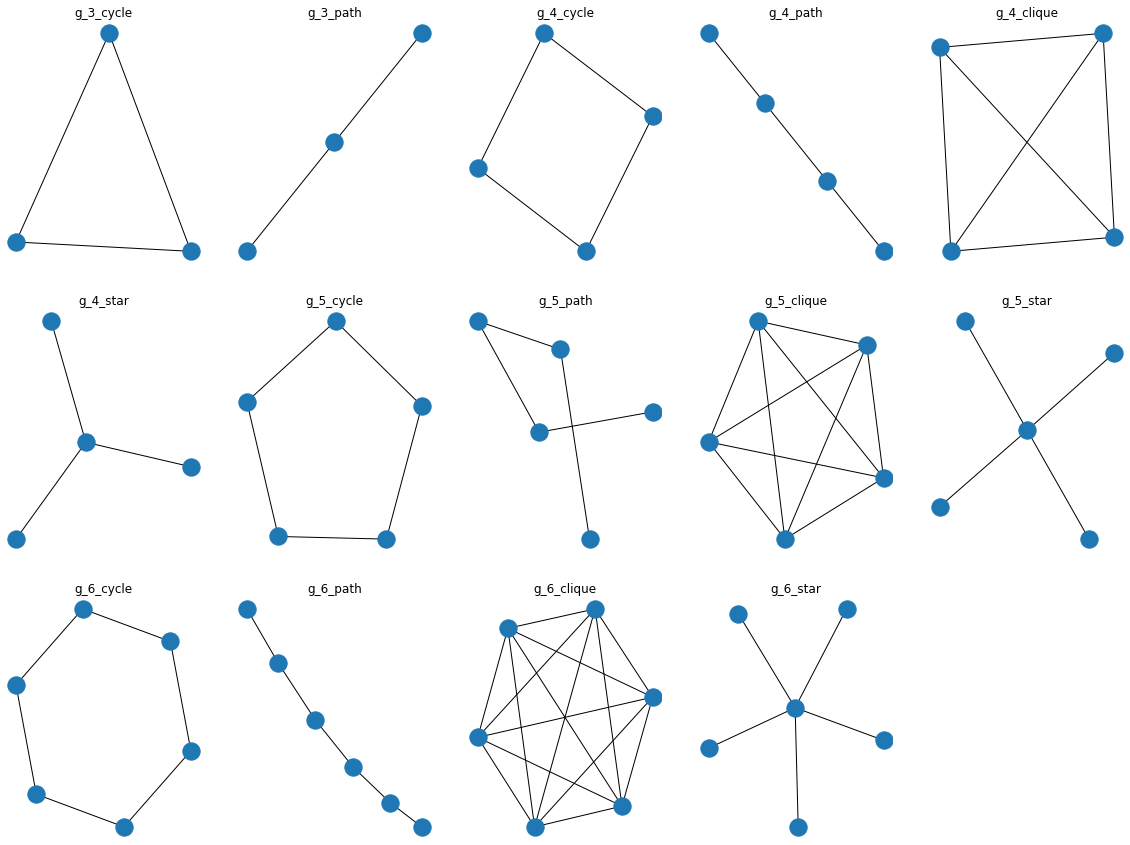

In [35]:
print_graphs(connected_graphs_components)

# run 2

In [30]:
data1 = pd.DataFrame(np.loadtxt(name + '\data_X_3_.txt'))
data1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,...,1070,1071,1072,1073,1074,1075,1076,1077,1078,1079,1080,1081,1082,1083,1084,1085,1086,1087,1088,1089,1090,1091,1092,1093,1094,1095,1096,1097,1098,1099,1100,1101,1102,1103,1104,1105,1106,1107,1108,1109,1110,1111,1112,1113,1114,1115,1116,1117,1118,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128,1129,1130,1131,1132,1133,1134,1135,1136,1137,1138,1139,1140,1141,1142,1143,1144
0,28.0,0.0,7.0,31.0,0.0,0.0,0.0,0.0,0.0,35.0,0.0,0.0,37.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,36.0,0.0,8.0,49.0,0.0,0.0,0.0,1.0,0.0,64.0,0.0,0.0,63.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,44.0,0.0,18.0,53.0,0.0,0.0,3.0,0.0,0.0,62.0,0.0,0.0,58.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13.0,0.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,44.0,0.0,10.0,60.0,0.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0,87.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,31.0,0.0,8.0,38.0,0.0,0.0,0.0,0.0,0.0,45.0,0.0,0.0,43.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,37.0,0.0,9.0,44.0,0.0,0.0,0.0,0.0,0.0,49.0,0.0,0.0,50.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,

In [26]:
myDataY = np.loadtxt('NCI1_Y.txt')

In [27]:
myDataY

array([0., 0., 0., ..., 1., 1., 1.])

In [42]:

#pickle.dump( myDataX, open( "NCI109_HOG_myDataX.p", "wb" ) )
#pickle.dump( myDataY, open( "NCI109_HOG_myDataY.p", "wb" ) )


# k-fold 

In [52]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

data_X = data1
data_y = np.array(myDataY)
print('Data shape is: ', data_X.shape)
acc_arr = []
K_FOLD = 10
kf = StratifiedKFold(n_splits=K_FOLD, random_state = 11111, shuffle = True)
pbar = tqdm_notebook(range(K_FOLD), desc="Training on K-fold")
t0 = time.time()
for train_index, test_index in kf.split(data_X, data_y):
    X_train, X_test = data_X.iloc[train_index], data_X.iloc[test_index]
    y_train, y_test = data_y[train_index], data_y[test_index]
    
    print('Train shape', X_train.shape,'Test shape', X_test.shape)
    model = return_grid_search_random_forest()
    model.fit(X_train, y_train.ravel())
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    acc_arr.append(acc)
    print(acc)
    pbar.update(1)
pbar.close()

print('Time taken(sec)', time.time()-t0)
np.mean(acc_arr)* 100

Data shape is:  (4110, 1145)


Train shape (3698, 1145) Test shape (412, 1145)
0.7985436893203883
Train shape (3698, 1145) Test shape (412, 1145)
0.7985436893203883
Train shape (3698, 1145) Test shape (412, 1145)
0.7888349514563107
Train shape (3699, 1145) Test shape (411, 1145)
0.8029197080291971
Train shape (3699, 1145) Test shape (411, 1145)
0.805352798053528
Train shape (3699, 1145) Test shape (411, 1145)
0.7883211678832117
Train shape (3699, 1145) Test shape (411, 1145)
0.8272506082725061
Train shape (3700, 1145) Test shape (410, 1145)
0.8
Train shape (3700, 1145) Test shape (410, 1145)
0.8121951219512196
Train shape (3700, 1145) Test shape (410, 1145)
0.7975609756097561

Time taken(sec) 10.364677667617798


80.19522709896506

74.2574546870832

In [38]:
data_X = data1
data_y = np.array(myDataY)
max_arr= []
#,567,890,5678,78, 6,1122,101,11111,42
for seed in [345]:
    estimator  = RandomForestClassifier(criterion='gini', max_depth=None, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                                            max_leaf_nodes=None, bootstrap=True, 
                                            oob_score=False, n_jobs=6,verbose=0, warm_start=False,
                                            class_weight=None)

    param_grid = {'n_estimators':[50,100,500], 'max_features':['sqrt'], 'min_samples_split':[2,3,4,5]}
    kf = StratifiedKFold(n_splits=10, random_state = seed)
    grid_rf    = GridSearchCV(estimator, param_grid, scoring=None, fit_params=None, n_jobs=6, 
                 iid=False, refit=True, cv=kf, verbose=3, pre_dispatch='n_jobs', 
                 error_score='raise-deprecating')
    #print(data_X.shape)
    grid_rf.fit(data_X, data_y)
    grid_rf.fit(data_X, data_y)
    df = pd.DataFrame(grid_rf.grid_scores_)
    max_arr.append(df['mean_validation_score'].max())
    #grid_rf.cv_results_['mean_test_score']
    #Pipeline2 = Pipeline([('drop_empty_column', dropCols(frac=1.0)),('grid_rf', grid_rf)])
    #res = Pipeline2.fit(data_X, data_y)
    print('Result computed for', filename, 'results are:',np.mean(max_arr))

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  26 tasks      | elapsed:   53.6s
[Parallel(n_jobs=6)]: Done 120 out of 120 | elapsed:  3.2min finished


Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  26 tasks      | elapsed:   36.4s
[Parallel(n_jobs=6)]: Done 120 out of 120 | elapsed:  2.8min finished


AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [39]:
grid_rf.cv_results_

C:\Users\Zohai\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Zohai\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Zohai\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Zohai\Anaconda3\lib\site-packages\sklearn\util

{'mean_fit_time': array([ 1.43783591,  2.53911266, 15.53738282,  2.08113763,  2.624189  ,
        14.61285141,  2.16072502,  2.36877012, 14.55351179,  2.13110125,
         2.55916173, 14.42206075]),
 'std_fit_time': array([0.40245466, 0.57269829, 1.01044903, 1.01145893, 0.49455099,
        1.54252716, 0.93414432, 0.54678596, 0.34354277, 1.26067934,
        0.45403548, 2.37960354]),
 'mean_score_time': array([0.52373116, 0.80953882, 0.9578378 , 0.66133275, 0.62453601,
        1.14204669, 0.95854073, 0.76694989, 0.9710027 , 0.77233772,
        0.4967736 , 0.96452372]),
 'std_score_time': array([0.34211424, 0.67947226, 0.37766871, 0.72041445, 0.36211028,
        0.72610529, 0.58168037, 0.63795254, 0.57768748, 0.53256454,
        0.42238516, 0.48496818]),
 'param_max_features': masked_array(data=['sqrt', 'sqrt', 'sqrt', 'sqrt', 'sqrt', 'sqrt', 'sqrt',
                    'sqrt', 'sqrt', 'sqrt', 'sqrt', 'sqrt'],
              mask=[False, False, False, False, False, False, False, False,
   

In [85]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state = 42)

estimator  = RandomForestClassifier(criterion='gini', max_depth=None, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                                    max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, 
                                    oob_score=False, n_jobs=8, random_state=666, verbose=0, warm_start=False,
                                    class_weight=None)

param_grid = {'n_estimators':[250,500,1000], 'max_features':[None, 'sqrt'], 'min_samples_split':[3,4,5]}
grid_rf    = GridSearchCV(estimator, param_grid, scoring=None, fit_params=None, n_jobs=8, 
             iid=False, refit=True, cv=kf, verbose=10, pre_dispatch='2*n_jobs', 
             error_score='raise-deprecating', return_train_score='warn')

#input your paramaters here        
grid_rf.fit(data_X, data_y)

print(grid_rf.cv_results_['mean_test_score'])
print('Max score is:', max(grid_rf.cv_results_['mean_test_score']))

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:  3.2min
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:  6.4min
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed: 11.0min
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed: 27.0min
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed: 32.0min
[Parallel(n_jobs=8)]: Done  45 tasks      | elapsed: 41.3min
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed: 58.2min
[Parallel(n_jobs=8)]: Done  69 tasks      | elapsed: 67.6min
[Parallel(n_jobs=8)]: Done  82 tasks      | elapsed: 83.1min
[Parallel(n_jobs=8)]: Done  97 tasks      | elapsed: 88.1min
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed: 89.4min
[Parallel(n_jobs=8)]: Done 129 tasks      | elapsed: 90.6min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed: 92.2min
[Parallel(n_jobs=8)]: Done 165 tasks      | elapsed: 92.8min
[Parallel(n_jobs=8)]: Done 180 out of 180 | elapsed: 93.6min finished


[0.79952452 0.80779232 0.80462988 0.80098379 0.80852284 0.80633601
 0.7987946  0.8048726  0.80487083 0.80779469 0.80536455 0.80706831
 0.80974531 0.80950377 0.8090213  0.80804629 0.80682915 0.81023549]
Max score is: 0.8102354877386206


In [1]:
import networkx as nx

In [2]:
from tqdm import tqdm

In [3]:
for i in tqdm(range(100)):
    1

100%|████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 100102.72it/s]


In [ ]:
nx.isomorphism.M

In [4]:
import concurrent.futures
import random               # add some random sleep time


def procedure(j):                 # just factoring out the
    return j * j        # procedure
    # call the calculation

def main():
    output1 = list()      # let's see how long this takes

    # we can swap out ProcessPoolExecutor for ThreadPoolExecutor
    with concurrent.futures.ProcessPoolExecutor(max_workers=3) as executor:
        for out1 in executor.map(procedure, range(0, 10)):
            # put results into correct output list
            output1.append(out1)
            
    # these kinds of format strings are only available on Python 3.6:
    # time to upgrade!
    print(f'original inputs: {repr(output1)}')
    

if __name__ == '__main__':
    main()

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

In [7]:
import numpy as np

In [8]:
arguments = np.array([['a'+str(i) for i in range(5)], ['b'+str(i) for i in range(5)], ['c'+str(i) for i in range(5)], ['d'+str(i) for i in range(5)]])

In [16]:
arguments.T.shape

(5, 4)

In [27]:
import pickle, copy
import networkx as nx 
from collections import OrderedDict 
import math

def ret_minmax(results, key):

    globMin = 110
    globMax = 0
    globMinG = 0
    globMaxG = 0

    #for key in connected_graphs_components.keys():
    #key = 'g_6_55'
    some = False
    for graph_item in results:
        if (len(graph_item['compressedGs'][key]['degreeList']) == 0):
            continue
        some = True
        possMin = np.min(graph_item['compressedGs'][key]['degreeList'])
        possMax = np.max(graph_item['compressedGs'][key]['degreeList'])

        if (possMax > globMax):
            globMax = possMax
            #globMaxG = graph_item['graph']
        if (possMin < globMin):
            globMin = possMin
            #globMinG = graph_item['graph']

    #print(" Max: ", globMax, " Min: ", globMin)
    glob = {}
    if (some == True):
        glob['min'] = globMin
        glob['max'] = globMax
    return glob


lim = 6

connected_graphs_components = OrderedDict()
for i in range(4,lim+1):
    name_pre = 'g_'+str(i)+'_'
    connected_graphs_components[name_pre+'cycle'] = nx.cycle_graph(i)
    connected_graphs_components[name_pre+'path'] = nx.path_graph(i)
    connected_graphs_components[name_pre+'clique'] = nx.complete_graph(i)
    connected_graphs_components[name_pre+'star'] = nx.star_graph(i-1)
        
name = 'MUTAG'
results = pickle.load( open( name+"/"+name + "_G_0-200.p", "rb" ) )
glob = {}

for k in connected_graphs_components.keys():
    retD = ret_minmax(results, k)
    if (len(retD) > 0):
        glob[k] = retD
for k, v in glob.items():
    v['max'] = math.ceil(v['max'])
    v['min'] = math.floor(v['min'])

dataX_1 = []
dataX_2 = []
dataX_3 = []
dataX_4 = []

binD = 10

for graph_item in results:
    data_item = copy.copy(graph_item['HoG'])
    data_item2 = copy.copy(graph_item['HoG'])
    data_item3 = copy.copy(graph_item['HoG'])
    data_item4 = copy.copy(graph_item['HoG'])

    data_item.append(graph_item['nodes'])
    data_item2.append(graph_item['nodes'])
    data_item3.append(graph_item['nodes'])
    data_item4.append(graph_item['nodes'])

    data_item.append(graph_item['edges'])
    data_item2.append(graph_item['edges'])
    data_item3.append(graph_item['edges'])
    data_item4.append(graph_item['edges'])

    for key, value in graph_item['compressedGs'].items():
        if ((key not in glob.keys())):
            continue

        globMin = glob[key]['min']
        globMax = glob[key]['max']

        # set binwidth for this histogram
        binW = binD*(globMax-globMin)
        if (binW == 0):
            binW = 1

        # make histogram of degrees
        degreeHist = [0] * binW
        avDegrees = value['degreeList']
        if (len(avDegrees) > 0):
            #print(binW)
            hist, bin_edges = np.histogram(avDegrees, bins=binW, range=(globMin, globMax), normed=None, weights=None, density=None)
            degreeHist = hist.tolist()

        data_item += degreeHist
        data_item2 += degreeHist
        data_item3 += degreeHist
        data_item4 += degreeHist


        data_item += value['nodes']
        data_item2 += value['nodes']
        data_item3 += value['nodes']
        data_item4 += value['nodes']

        data_item += value['edges']
        data_item2 += value['edges']
        data_item3 += value['edges']
        data_item4 += value['edges']

        thisHoGD = [x-y for x, y in zip(value['HoG'], value['HoGN'])] 

        if (not all(item >= 0 for item in thisHoGD)):
            print("error")

        #data_item += thisHoGD
        #data_item += value['HoGN2']

        #data_item2 = copy.copy(data_item)
        #data_item3 = copy.copy(data_item)
        data_item += value['HoG']
        data_item4 += value['HoG']

        data_item2 += thisHoGD
        data_item3 += thisHoGD
        data_item4 += thisHoGD

        data_item2 += value['HoGN']
        data_item3 += value['HoGN2']


        data_item4 += value['HoGN']
        data_item4 += value['HoGN2']


    dataX_1.append(data_item)
    dataX_2.append(data_item2)
    dataX_3.append(data_item3)
    dataX_4.append(data_item4)


dataX_1_ = np.array(dataX_1)
dataX_2_ = np.array(dataX_2)
dataX_3_ = np.array(dataX_3)
dataX_4_ = np.array(dataX_4)

data_X_1_ = dataX_1_[:,~np.all(dataX_1_==0,axis=0)]
data_X_2_ = dataX_2_[:,~np.all(dataX_2_==0,axis=0)]
data_X_3_ = dataX_3_[:,~np.all(dataX_3_==0,axis=0)]
data_X_4_ = dataX_4_[:,~np.all(dataX_4_==0,axis=0)]



In [28]:
data_X_1_[0]

array([27, 37,  6,  0, 49,  0,  3, 48, 17, 19,  0,  0,  1,  0,  0,  1,  0,
        0,  0,  1,  0,  0,  0,  0,  3,  3,  1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  4,  3,  0,
        3,  0,  0,  1,  0,  0,  0,  0,  0,  0,  1,  0,  0,  1])

In [14]:
G = nx.erdos_renyi_graph(10,0.4)

In [15]:
c = list(connected_component_subgraphs(G))

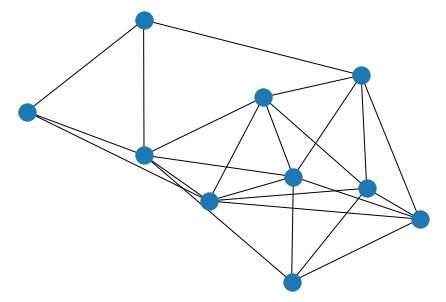

In [19]:
nx.draw(c[0])

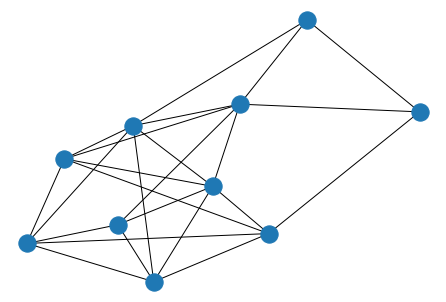

In [20]:
nx.draw(G)

In [21]:
def return_connected_components(n=5):
	CONNECTED_COMPONENTS_PATH   = 'graphs'
	dirs = []
	connected_graphs_components = {}
	for i in os.listdir(CONNECTED_COMPONENTS_PATH):
		if n >= int(i[3:]):
			dirs.append(i)

	for path in dirs:
		for count,file in enumerate(os.listdir(os.path.join(CONNECTED_COMPONENTS_PATH, path))): 
			file_path = os.path.join(CONNECTED_COMPONENTS_PATH, path, file)
			if file_path.endswith('.txt'): 
				connected_graph = np.loadtxt(file_path)
				connected_graphs_components['g_'+path[3:]+'_'+str(count+1)] =  nx.from_numpy_array(np.array(connected_graph))
	return connected_graphs_components


In [22]:
def return_connected_components(n=5):
	CONNECTED_COMPONENTS_PATH   = 'graphs'
	dirs = []
	connected_graphs_components = {}
	for i in os.listdir(CONNECTED_COMPONENTS_PATH):
		if n >= int(i[3:]):
			dirs.append(i)

	for path in dirs:
		for count,file in enumerate(os.listdir(os.path.join(CONNECTED_COMPONENTS_PATH, path))): 
			file_path = os.path.join(CONNECTED_COMPONENTS_PATH, path, file)
			if file_path.endswith('.txt'): 
				connected_graph = np.loadtxt(file_path)
				connected_graphs_components['g_'+path[3:]+'_'+str(count+1)] =  nx.from_numpy_array(np.array(connected_graph))
	return connected_graphs_components

connected_graphs_components = return_connected_components(n=6)


curr  = return_connected_components(n=6)

only_keep = ['g_3_1', 'g_4_2', 'g_5_21', 'g_6_24', 
			 'g_4_1', 'g_5_1', 'g_6_1', 
			 'g_3_2', 'g_4_4', 'g_5_6', 'g_6_55', 
			 'g_4_6', 'g_5_14', 'g_6_16']
			 
connected_graphs_components = OrderedDict()

for key, val in curr.items():
	if (key in only_keep):
		connected_graphs_components[key] = curr[key]
        


In [ ]:
connected_graphs_components = OrderedDict()
lim = 6

connected_graphs_components['g_3_cycle'] = nx.cycle_graph(3)
connected_graphs_components['g_3_path'] = nx.path_graph(3)


for i in range(4,lim+1):
    name_pre = 'g_'+str(i)+'_'
    connected_graphs_components[name_pre+'cycle'] = nx.cycle_graph(i)
    connected_graphs_components[name_pre+'path'] = nx.path_graph(i)
    connected_graphs_components[name_pre+'clique'] = nx.complete_graph(i)
    connected_graphs_components[name_pre+'star'] = nx.star_graph(i-1)

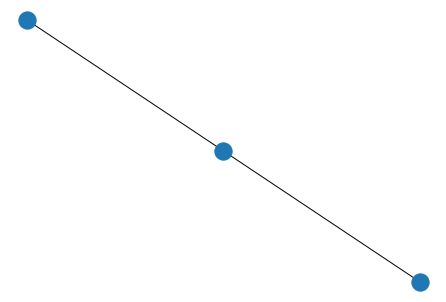

In [25]:
nx.draw(connected_graphs_components['g_3_1'])